#### Tasks:	 
1)	Write a SQL Query combining vendors to calculate the Oct CPM by platform.

2)	Analyze the data from Vendor U and provide 3 insights and 3 recommendations.

3) 	Prepare a one slide executive summary of your findings from 1 & 2. 

#### Notes:
* CPM = Estimated revenue / Sold Impressions * 1000
* Vendors = vendor_s + vendor_u + vendor_t

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", -1)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_context("paper", font_scale=1.8)
sns.set_palette("GnBu_d")

import pandas_profiling
import sqlite3

In [2]:
!pwd

/Users/valmadrid/DataScienceBootcamp/Projects/Others/SQL-Challenge


Creates a connection to c1 sqlite database:

In [3]:
conn = sqlite3.connect("c1.sqlite")
cur = conn.cursor()

Checks what is currently in this databse:

In [4]:
cur.execute(
    """
    SELECT type, name, tbl_name, rootpage, sql 
    FROM sqlite_master ORDER by type, tbl_name;
    """
)
db = pd.DataFrame(cur.fetchall(), columns=[i[0] for i in cur.description])
db

,type,name,tbl_name,rootpage,sql
0,table,definitions_fields,definitions_fields,42,"CREATE TABLE ""definitions_fields"" (\n""Unnamed: 0"" TEXT,\n ""Standardized field names"" TEXT,\n ""Unnamed: 2"" TEXT,\n ""Unnamed: 3"" TEXT,\n ""Unnamed: 4"" TEXT,\n ""Unnamed: 5"" TEXT\n)"
1,table,definitions_groupings,definitions_groupings,41,"CREATE TABLE ""definitions_groupings"" (\n""Vendor "" TEXT,\n ""tagID"" TEXT,\n ""Zone Name"" TEXT,\n ""Platform"" TEXT,\n ""Ad Products"" TEXT\n)"
2,table,oct_table,oct_table,44,"CREATE TABLE oct_table(\n vendor,\n date,\n mapper INT,\n zone_name TEXT,\n platform TEXT,\n ad_products TEXT,\n sold_impressions INT,\n est_revenue REAL,\n cpm REAL\n)"
3,table,question,question,43,"CREATE TABLE ""question"" (\n""Time Limit: 3 hours"" TEXT,\n ""Unnamed: 1"" TEXT\n)"
4,table,vendor_b,vendor_b,24,"CREATE TABLE ""vendor_b"" (\n""DATE_INTERVAL"" TEXT,\n ""TAGS"" TEXT,\n ""SIZE"" TEXT,\n ""RECEIVED_IMPS"" INTEGER,\n ""IMPS"" INTEGER,\n ""REVENUE"" REAL,\n ""CLICKS"" INTEGER\n)"
5,table,vendor_s,vendor_s,2,"CREATE TABLE ""vendor_s"" (\n""TRAFFIC"" TEXT,\n ""TAG_ID"" INTEGER,\n ""TYPE"" TEXT,\n ""SITE"" TEXT,\n ""REQUESTS"" INTEGER,\n ""IMPRESSIONS"" INTEGER,\n ""FILL_RATE"" REAL,\n ""CPM"" REAL,\n ""EARNINGS"" REAL,\n ""UPDATED_DATE"" TIMESTAMP\n)"
6,table,vendor_t,vendor_t,25,"CREATE TABLE ""vendor_t"" (\n""WEBSITE"" TEXT,\n ""PLACEMENT"" TEXT,\n ""DAY"" TIMESTAMP,\n ""PUBLISHER_BILLABLE_VOLUME"" INTEGER,\n ""CLICK"" INTEGER,\n ""TEADS_BILLING_USD"" TEXT\n)"
7,table,vendor_u,vendor_u,11,"CREATE TABLE ""vendor_u"" (\n""PLATFORM"" TEXT,\n ""DATE"" TIMESTAMP,\n ""DEVICE_TYPE"" TEXT,\n ""VIDEO_IMPRESSIONS"" INTEGER,\n ""EARNINGS"" REAL,\n ""CLICKS"" INTEGER\n)"


Previews the tables in the xlsx file:

In [5]:
df_excel = pd.read_excel("source_1.xlsx", sheet_name=None)

for name, table in df_excel.items():
    display(name)
    display(table.head())

'vendor_s'

,TRAFFIC,TAG_ID,TYPE,SITE,REQUESTS,IMPRESSIONS,FILL_RATE,CPM,EARNINGS,UPDATED_DATE
0,Combined,467649,DISPLAY,all traffic,511918,481718,0.94,0.14,67.75,2017-10-21
1,Combined,468681,DISPLAY,all traffic,439230,142757,0.33,0.15,20.80,2017-10-21
2,Combined,482946,DISPLAY,all traffic,167608,20837,0.12,0.13,2.74,2017-10-21
3,Combined,504560,DISPLAY,all traffic,175971,13414,0.08,0.27,3.66,2017-10-21
4,Combined,482944,DISPLAY,all traffic,284197,111739,0.39,0.13,14.15,2017-10-21


'vendor_u'

,PLATFORM,DATE,DEVICE_TYPE,VIDEO_IMPRESSIONS,EARNINGS,CLICKS
0,Unruly,2017-04-14,Desktop,4265,0.00,1073
1,Unruly,2017-02-13,Desktop,8585,0.00,1286
2,Unruly,2017-02-25,Desktop,2806,0.00,282
3,Unruly,2017-01-02,Desktop,1801,0.00,371
4,Unruly,2017-03-19,Desktop,6241,0.00,51


'vendor_b'

,DATE_INTERVAL,TAGS,SIZE,RECEIVED_IMPS,IMPS,REVENUE,CLICKS
0,"Oct 11, 2017",scmp.com_Dkt (21895),728x90,58400,31228,2.08,8349
1,"Oct 11, 2017",scmp.com_Dkt (21895),300x250,39645,9935,16.17,1245
2,"Oct 11, 2017",scmp.com_Mob (21917),300x250,128795,124022,9.37,59713
3,"Oct 19, 2017",scmp.com_Dkt (21895),728x90,59581,51182,56.78,21983
4,"Oct 19, 2017",scmp.com_Dkt (21895),300x250,84681,45925,12.84,12453


'vendor_t'

,WEBSITE,PLACEMENT,DAY,PUBLISHER_BILLABLE_VOLUME,CLICK,TEADS_BILLING_USD
0,32277 - scmp.com,48540 - MS-inRead-Mobile-scmp.com,2017-10-08,904,250,40.38 USD
1,32277 - scmp.com,48540 - MS-inRead-Mobile-scmp.com,2017-10-08,4382,969,32.25 USD
2,32277 - scmp.com,48540 - MS-inRead-Mobile-scmp.com,2017-10-08,868,234,39.27 USD
3,32277 - scmp.com,48540 - MS-inRead-Mobile-scmp.com,2017-10-08,3738,237,9.26 USD
4,32277 - scmp.com,48540 - MS-inRead-Mobile-scmp.com,2017-10-08,3270,1078,48.09 USD


'Definitions - Groupings'

,Vendor,tagID,Zone Name,Platform,Ad Products
0,S,482944,ROS,Desktop,Island Ad 2
1,NaN,467645,ROS,Mobile Web,Island Ad 1
2,NaN,501047,ROS,Desktop,Island Ad 2
3,NaN,464637,ROS,Desktop,Super Leaderboard / Billboard
4,NaN,464635,ROS,Desktop,Island Ad 1


'Definitions - Fields'

,Unnamed: 0,Standardized field names,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,Vendor,Date,Ad request,Sold Impressions,No Of Clicks,Estimated revenue
1,S,UPDATED_DATE,Requests,Impressions,NaN,Earnings
2,U*,DATE,NaN,video impressions,Clicks,Earnings
3,B,Date Interval,Received IMPS,IMPS,Clicks,Revenue
4,T,DAY,NaN,publisher_billable_volume,Click,teads_billing_usd


'Question'

,Time Limit: 3 hours,Unnamed: 1
0,NaN,NaN
1,1),Write a SQL Query combining vendors to calculate the Oct CPM by platform.
2,NaN,NaN
3,2),Analyze the data from Vendor U and provide 3 insights and 3 recommendations.
4,NaN,NaN


Adds the xlsx to sqlite database:

In [6]:
for table, df in df_excel.items():
    table_name=table.lower().replace("-","_").replace(" ","")
    df.to_sql(table_name, conn, if_exists="replace", index=False)
    print("{} added to c1.sqlite\n".format(table_name))

vendor_s added to c1.sqlite

vendor_u added to c1.sqlite

vendor_b added to c1.sqlite

vendor_t added to c1.sqlite

definitions_groupings added to c1.sqlite

definitions_fields added to c1.sqlite

question added to c1.sqlite



/Applications/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:2712: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [7]:
cur.execute(
    """
    SELECT type, name, tbl_name, rootpage, sql 
    fROM sqlite_master 
    ORDER by type, tbl_name;
    """
)
db = pd.DataFrame(cur.fetchall(), columns=[i[0] for i in cur.description])
db

,type,name,tbl_name,rootpage,sql
0,table,definitions_fields,definitions_fields,42,"CREATE TABLE ""definitions_fields"" (\n""Unnamed: 0"" TEXT,\n ""Standardized field names"" TEXT,\n ""Unnamed: 2"" TEXT,\n ""Unnamed: 3"" TEXT,\n ""Unnamed: 4"" TEXT,\n ""Unnamed: 5"" TEXT\n)"
1,table,definitions_groupings,definitions_groupings,41,"CREATE TABLE ""definitions_groupings"" (\n""Vendor "" TEXT,\n ""tagID"" TEXT,\n ""Zone Name"" TEXT,\n ""Platform"" TEXT,\n ""Ad Products"" TEXT\n)"
2,table,oct_table,oct_table,44,"CREATE TABLE oct_table(\n vendor,\n date,\n mapper INT,\n zone_name TEXT,\n platform TEXT,\n ad_products TEXT,\n sold_impressions INT,\n est_revenue REAL,\n cpm REAL\n)"
3,table,question,question,43,"CREATE TABLE ""question"" (\n""Time Limit: 3 hours"" TEXT,\n ""Unnamed: 1"" TEXT\n)"
4,table,vendor_b,vendor_b,24,"CREATE TABLE ""vendor_b"" (\n""DATE_INTERVAL"" TEXT,\n ""TAGS"" TEXT,\n ""SIZE"" TEXT,\n ""RECEIVED_IMPS"" INTEGER,\n ""IMPS"" INTEGER,\n ""REVENUE"" REAL,\n ""CLICKS"" INTEGER\n)"
5,table,vendor_s,vendor_s,2,"CREATE TABLE ""vendor_s"" (\n""TRAFFIC"" TEXT,\n ""TAG_ID"" INTEGER,\n ""TYPE"" TEXT,\n ""SITE"" TEXT,\n ""REQUESTS"" INTEGER,\n ""IMPRESSIONS"" INTEGER,\n ""FILL_RATE"" REAL,\n ""CPM"" REAL,\n ""EARNINGS"" REAL,\n ""UPDATED_DATE"" TIMESTAMP\n)"
6,table,vendor_t,vendor_t,25,"CREATE TABLE ""vendor_t"" (\n""WEBSITE"" TEXT,\n ""PLACEMENT"" TEXT,\n ""DAY"" TIMESTAMP,\n ""PUBLISHER_BILLABLE_VOLUME"" INTEGER,\n ""CLICK"" INTEGER,\n ""TEADS_BILLING_USD"" TEXT\n)"
7,table,vendor_u,vendor_u,11,"CREATE TABLE ""vendor_u"" (\n""PLATFORM"" TEXT,\n ""DATE"" TIMESTAMP,\n ""DEVICE_TYPE"" TEXT,\n ""VIDEO_IMPRESSIONS"" INTEGER,\n ""EARNINGS"" REAL,\n ""CLICKS"" INTEGER\n)"


#### Vendor S

Checks max and min dates:

In [8]:
cur.execute("""SELECT MAX(UPDATED_DATE) FROM vendor_s;""")
display(cur.fetchall())
cur.execute("""SELECT MIN(UPDATED_DATE) FROM vendor_s;""")
display(cur.fetchall())

[('2017-11-04 00:00:00',)]

[('2017-10-12 00:00:00',)]

In [9]:
cur.execute(
    """
    SELECT 
        "S" as vendor,
        s.UPDATED_Date as date,
        s.TAG_ID as mapper,
        groupings."Zone Name" as zone_name,
        groupings.Platform as platform, 
        groupings."Ad Products" as ad_products, 
        s.IMPRESSIONS as sold_impressions, 
        s.EARNINGS as est_revenue, 
        s.CPM as cpm
    FROM vendor_s as s
    LEFT JOIN definitions_groupings as groupings
        ON s.TAG_ID = groupings.tagID
    WHERE UPDATED_DATE BETWEEN '2017-10-01' AND '2017-10-31 59:59:59';
    """
)
vendor_s = pd.DataFrame(cur.fetchall(),
                     columns=[i[0] for i in cur.description])
vendor_s.head()

,vendor,date,mapper,zone_name,platform,ad_products,sold_impressions,est_revenue,cpm
0,S,2017-10-21 00:00:00,467649,ROS,Desktop,Super Leaderboard / Billboard,481718,67.75,0.14
1,S,2017-10-21 00:00:00,468681,ROS,Desktop,Super Leaderboard / Billboard,142757,20.80,0.15
2,S,2017-10-21 00:00:00,482946,ROS,Desktop,Island Ad 2,20837,2.74,0.13
3,S,2017-10-21 00:00:00,504560,ROS,Mobile Web,Island Ad 2,13414,3.66,0.27
4,S,2017-10-21 00:00:00,482944,ROS,Desktop,Island Ad 2,111739,14.15,0.13


In [10]:
sum(vendor_s.cpm)

132.69000000000014

In [11]:
check = df_excel["vendor_s"].copy()
check = check[(check.UPDATED_DATE <= "2017-10-31") & (check.UPDATED_DATE >= "2017-10-01")].sort_values("UPDATED_DATE")
sum(check.CPM)

132.69000000000005

#### Vendor U

Checks max and min dates:

In [12]:
cur.execute("""SELECT MAX(DATE) FROM vendor_u;""")
display(cur.fetchall())
cur.execute("""SELECT MIN(DATE) FROM vendor_u;""")
display(cur.fetchall())

[('2017-10-29 00:00:00',)]

[('2017-01-01 00:00:00',)]

In [13]:
cur.execute("""
    SELECT 
        "U" as vendor,
        u.DATE as date,
        u.DEVICE_TYPE as mapper,
        groupings."Zone Name" as zone_name,
        groupings.Platform as platform, 
        groupings."Ad Products" as ad_products,
        u.VIDEO_IMPRESSIONS as sold_impressions,
        (CAST(u.VIDEO_IMPRESSIONS as REAL) / map.total_sold_impressions * map.total_est_revenue)*1.00 as est_revenue,
        (CAST(u.VIDEO_IMPRESSIONS as REAL) / map.total_sold_impressions * map.total_est_revenue)/CAST(u.VIDEO_IMPRESSIONS as REAL)*1000.00 as cpm
    FROM vendor_u as u
    LEFT JOIN (SELECT
                    DATE as date,
                    CAST(sum(VIDEO_IMPRESSIONS) as REAL) as total_sold_impressions,
                    CAST(sum(EARNINGS) as REAL) as total_est_revenue
                FROM vendor_u
                WHERE DATE BETWEEN '2017-10-01' AND '2017-10-31'
                GROUP by DATE) as map
        USING (DATE)
    LEFT JOIN definitions_groupings as groupings
        ON lower(u.DEVICE_TYPE) = lower(groupings.tagID)
    WHERE
        (DATE BETWEEN '2017-10-01' AND '2017-10-31') &
        (DEVICE_TYPE NOT LIKE "%UNKNOWN%")
    """)

vendor_u = pd.DataFrame(cur.fetchall(),
                             columns=[i[0] for i in cur.description])
vendor_u.head()

,vendor,date,mapper,zone_name,platform,ad_products,sold_impressions,est_revenue,cpm
0,U,2017-10-28 00:00:00,Desktop,ROS,Desktop,Full Page Ad/Inread Video,624,8.42,13.50
1,U,2017-10-04 00:00:00,Desktop,ROS,Desktop,Full Page Ad/Inread Video,9248,26.52,2.87
2,U,2017-10-07 00:00:00,Desktop,ROS,Desktop,Full Page Ad/Inread Video,348,0.99,2.84
3,U,2017-10-29 00:00:00,Desktop,ROS,Desktop,Full Page Ad/Inread Video,7487,9.84,1.31
4,U,2017-10-27 00:00:00,Desktop,ROS,Desktop,Full Page Ad/Inread Video,2832,0.17,0.06


In [14]:
sum(vendor_u.est_revenue)

1539.3799999999997

In [15]:
vendor_u["check"] = vendor_u["est_revenue"]/vendor_u["sold_impressions"]*1000 - vendor_u["cpm"]
vendor_u.check.unique()

array([0.])

In [16]:
check = df_excel["vendor_u"].copy()
check = check[(check.DATE <= "2017-10-31") & (check.DATE >= "2017-10-01")].sort_values("DATE")
sum(check.EARNINGS)

1539.38

#### Vendor T

In [17]:
cur.execute("""SELECT MAX(DAY) FROM vendor_t;""")
display(cur.fetchall())
cur.execute("""SELECT MIN(DAY) FROM vendor_t;""")
display(cur.fetchall())

[('2017-11-03 00:00:00',)]

[('2017-10-08 00:00:00',)]

In [18]:
cur.execute(
    """
    SELECT 
        "T" as vendor,
        t.DAY as date,
        SUBSTR(t.PLACEMENT,1,5) as mapper,
        groupings."Zone Name" as zone_name,
        groupings.Platform as platform, 
        groupings."Ad Products" as ad_products,
        t.PUBLISHER_BILLABLE_VOLUME as sold_impressions, 
        CAST(RTRIM(t.TEADS_BILLING_USD, " USD") as REAL) as est_revenue,
        CAST(RTRIM(t.TEADS_BILLING_USD, " USD") as REAL)/CAST(t.PUBLISHER_BILLABLE_VOLUME as REAL)*1000 as cpm
    FROM vendor_t as t
    LEFT JOIN definitions_groupings as groupings
        ON SUBSTR(t.PLACEMENT,1,5) = SUBSTR(groupings.tagID,1,5)
    WHERE DAY BETWEEN '2017-10-01' AND '2017-10-31 59:59:59';
    """
)
vendor_t = pd.DataFrame(cur.fetchall(),
                     columns=[i[0] for i in cur.description])
vendor_t.head()

,vendor,date,mapper,zone_name,platform,ad_products,sold_impressions,est_revenue,cpm
0,T,2017-10-08 00:00:00,48540,ROS,Mobile Web,Full Page Ad/Inread Video,904,40.38,44.67
1,T,2017-10-08 00:00:00,48540,ROS,Mobile Web,Full Page Ad/Inread Video,4382,32.25,7.36
2,T,2017-10-08 00:00:00,48540,ROS,Mobile Web,Full Page Ad/Inread Video,868,39.27,45.24
3,T,2017-10-08 00:00:00,48540,ROS,Mobile Web,Full Page Ad/Inread Video,3738,9.26,2.48
4,T,2017-10-08 00:00:00,48540,ROS,Mobile Web,Full Page Ad/Inread Video,3270,48.09,14.71


In [19]:
sum(vendor_t.est_revenue)

18604.690000000006

In [20]:
vendor_t["check"] = vendor_t["est_revenue"]/vendor_t["sold_impressions"]*1000 - vendor_t["cpm"]
vendor_t.check.unique()

array([0.])

In [21]:
check = df_excel["vendor_t"].copy()
check = check[(check.DAY <= "2017-10-31") & (check.DAY >= "2017-10-01")].sort_values("DAY")
check["TEADS_BILLING_USD"] = check.TEADS_BILLING_USD.map(lambda x: float(x.strip("USD")))
sum(check.TEADS_BILLING_USD)

18604.689999999988

#### Total October 2017 CPM 

In [22]:
cur.execute("""DROP TABLE IF EXISTS oct_table;""")

cur.execute("""
    CREATE TABLE oct_table AS
        SELECT 
            "S" as vendor,
            STRFTIME("%Y-%m-%d", s.UPDATED_DATE) as date,
            s.TAG_ID as mapper,
            groupings."Zone Name" as zone_name,
            groupings.Platform as platform, 
            groupings."Ad Products" as ad_products, 
            s.IMPRESSIONS as sold_impressions, 
            s.EARNINGS as est_revenue, 
            s.CPM as cpm
        FROM vendor_s as s
        LEFT JOIN definitions_groupings as groupings
            ON s.TAG_ID = groupings.tagID
        WHERE UPDATED_DATE BETWEEN '2017-10-01' AND '2017-10-31 59:59:59'
        UNION
            SELECT 
                "U" as vendor,
                STRFTIME("%Y-%m-%d", u.DATE) as date,
                u.DEVICE_TYPE as mapper,
                groupings."Zone Name" as zone_name,
                groupings.Platform as platform, 
                groupings."Ad Products" as ad_products,
                u.VIDEO_IMPRESSIONS as sold_impressions,
                (CAST(u.VIDEO_IMPRESSIONS as REAL) / map.total_sold_impressions * map.total_est_revenue)*1.00 as est_revenue,
                (CAST(u.VIDEO_IMPRESSIONS as REAL) / map.total_sold_impressions * map.total_est_revenue)/CAST(u.VIDEO_IMPRESSIONS as REAL)*1000.00 as cpm
            FROM vendor_u as u
            LEFT JOIN (SELECT
                            DATE as date,
                            CAST(sum(VIDEO_IMPRESSIONS) as REAL) as total_sold_impressions,
                            CAST(sum(EARNINGS) as REAL) as total_est_revenue
                        FROM vendor_u
                        WHERE DATE BETWEEN '2017-10-01' AND '2017-10-31'
                        GROUP by DATE) as map
                USING (DATE)
            LEFT JOIN definitions_groupings as groupings
                ON lower(u.DEVICE_TYPE) = lower(groupings.tagID)
            WHERE
                (DATE BETWEEN '2017-10-01' AND '2017-10-31') &
                (DEVICE_TYPE NOT LIKE "%UNKNOWN%")
        UNION
            SELECT 
                "T" as vendor,
                STRFTIME("%Y-%m-%d", t.DAY) as date,
                SUBSTR(t.PLACEMENT,1,5) as mapper,
                groupings."Zone Name" as zone_name,
                groupings.Platform as platform, 
                groupings."Ad Products" as ad_products,
                t.PUBLISHER_BILLABLE_VOLUME as sold_impressions, 
                CAST(RTRIM(t.TEADS_BILLING_USD, " USD") as REAL) as est_revenue,
                CAST(RTRIM(t.TEADS_BILLING_USD, " USD") as REAL)/CAST(t.PUBLISHER_BILLABLE_VOLUME as REAL)*1000 as cpm
            FROM vendor_t as t
            LEFT JOIN definitions_groupings as groupings
                ON SUBSTR(t.PLACEMENT,1,5) = SUBSTR(groupings.tagID,1,5)
            WHERE DAY BETWEEN '2017-10-01' AND '2017-10-31 59:59:59';            
    """)

cur.execute(
    """SELECT *, STRFTIME("%d", DATE) as day FROM oct_table;"""
)

oct_cpm = pd.DataFrame(cur.fetchall(), columns=[i[0] for i in cur.description])
oct_cpm.head()

,vendor,date,mapper,zone_name,platform,ad_products,sold_impressions,est_revenue,cpm,day
0,S,2017-10-12,463809,homepage,Desktop,Island Ad 1,18579,2.04,0.11,12
1,S,2017-10-12,463812,ROS,Mobile Web,Island Ad 1,11867,3.43,0.29,12
2,S,2017-10-12,463814,homepage,Mobile Web,Island Ad 1,187545,44.68,0.24,12
3,S,2017-10-12,464635,ROS,Desktop,Island Ad 1,152476,41.43,0.27,12
4,S,2017-10-12,467644,ROS,Desktop,Island Ad 1,327473,9.95,0.03,12


In [23]:
cur.execute(
    """
    SELECT platform, sum(cpm) 
    FROM oct_table 
    GROUP BY platform
    ORDER BY sum(cpm) DESC;"""
)
display(cur.fetchall())
cur.execute(
    """
    SELECT sum(cpm) 
    FROM oct_table;"""
)

display(cur.fetchall())

[('Desktop', 5408.311438622353), ('Mobile Web', 3876.960096488767)]

[(9285.271535111102,)]

In [24]:
cur.execute(
    """
    SELECT type, name, tbl_name, rootpage, sql 
    fROM sqlite_master 
    ORDER by type, tbl_name;
    """
)
db = pd.DataFrame(cur.fetchall(), columns=[i[0] for i in cur.description])
db

,type,name,tbl_name,rootpage,sql
0,table,definitions_fields,definitions_fields,42,"CREATE TABLE ""definitions_fields"" (\n""Unnamed: 0"" TEXT,\n ""Standardized field names"" TEXT,\n ""Unnamed: 2"" TEXT,\n ""Unnamed: 3"" TEXT,\n ""Unnamed: 4"" TEXT,\n ""Unnamed: 5"" TEXT\n)"
1,table,definitions_groupings,definitions_groupings,41,"CREATE TABLE ""definitions_groupings"" (\n""Vendor "" TEXT,\n ""tagID"" TEXT,\n ""Zone Name"" TEXT,\n ""Platform"" TEXT,\n ""Ad Products"" TEXT\n)"
2,table,oct_table,oct_table,44,"CREATE TABLE oct_table(\n vendor,\n date,\n mapper INT,\n zone_name TEXT,\n platform TEXT,\n ad_products TEXT,\n sold_impressions INT,\n est_revenue REAL,\n cpm REAL\n)"
3,table,question,question,43,"CREATE TABLE ""question"" (\n""Time Limit: 3 hours"" TEXT,\n ""Unnamed: 1"" TEXT\n)"
4,table,vendor_b,vendor_b,24,"CREATE TABLE ""vendor_b"" (\n""DATE_INTERVAL"" TEXT,\n ""TAGS"" TEXT,\n ""SIZE"" TEXT,\n ""RECEIVED_IMPS"" INTEGER,\n ""IMPS"" INTEGER,\n ""REVENUE"" REAL,\n ""CLICKS"" INTEGER\n)"
5,table,vendor_s,vendor_s,2,"CREATE TABLE ""vendor_s"" (\n""TRAFFIC"" TEXT,\n ""TAG_ID"" INTEGER,\n ""TYPE"" TEXT,\n ""SITE"" TEXT,\n ""REQUESTS"" INTEGER,\n ""IMPRESSIONS"" INTEGER,\n ""FILL_RATE"" REAL,\n ""CPM"" REAL,\n ""EARNINGS"" REAL,\n ""UPDATED_DATE"" TIMESTAMP\n)"
6,table,vendor_t,vendor_t,25,"CREATE TABLE ""vendor_t"" (\n""WEBSITE"" TEXT,\n ""PLACEMENT"" TEXT,\n ""DAY"" TIMESTAMP,\n ""PUBLISHER_BILLABLE_VOLUME"" INTEGER,\n ""CLICK"" INTEGER,\n ""TEADS_BILLING_USD"" TEXT\n)"
7,table,vendor_u,vendor_u,11,"CREATE TABLE ""vendor_u"" (\n""PLATFORM"" TEXT,\n ""DATE"" TIMESTAMP,\n ""DEVICE_TYPE"" TEXT,\n ""VIDEO_IMPRESSIONS"" INTEGER,\n ""EARNINGS"" REAL,\n ""CLICKS"" INTEGER\n)"


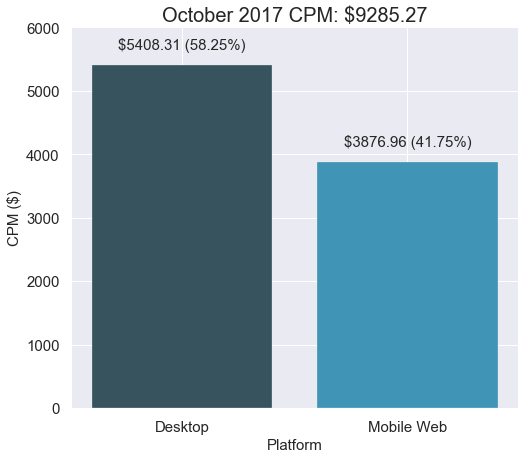

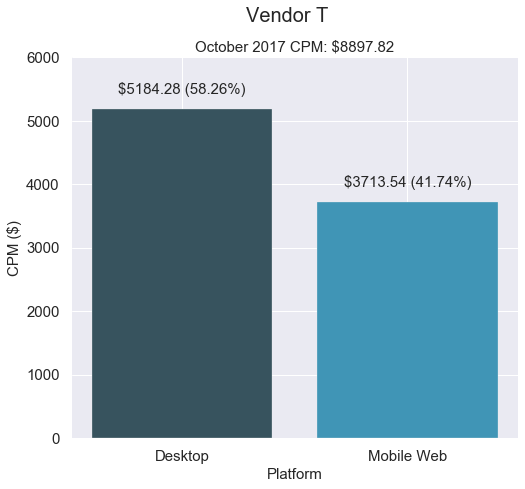

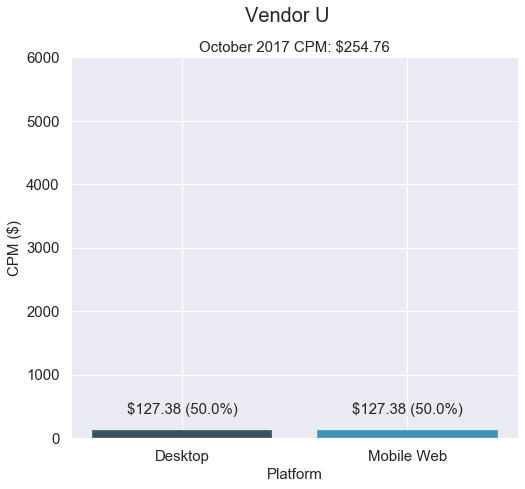

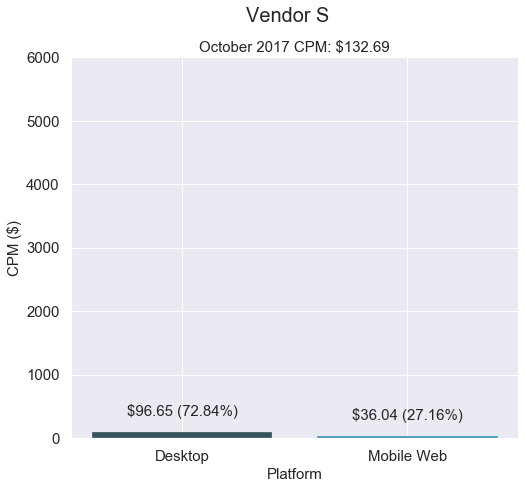

In [25]:
temp = oct_cpm.groupby(["platform"]).sum().reset_index()[["platform", "cpm"]].sort_values("cpm", ascending=False)
plt.figure(figsize=(8, 7))
graph = plt.bar(temp.platform, temp.cpm, color=["C0", "C2"])
plt.title("October 2017 CPM: ${}".format(round(sum(temp.cpm), 2)), fontsize=20)
plt.xlabel("Platform", fontsize=15)
plt.yticks(range(0, 7000, 1000),fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("CPM ($)",fontsize=15)
for bar, x in zip(graph, temp.cpm.values):
    plt.text(bar.get_x() + bar.get_width() / 2.0,
             bar.get_height() + 200,
             "${} ({}%)".format(round(x, 2),
                               round(x / sum(temp.cpm) * 100, 2)),
             fontsize=15,
             ha="center",
             va="bottom")
plt.show()

temp1 = oct_cpm.groupby(["vendor", "platform"]).sum().reset_index()[["vendor", "platform", "cpm"]].sort_values("cpm", ascending=False)
for i in ["T", "U", "S"]:
    temp = temp1[temp1.vendor==i]
    plt.figure(figsize=(8, 7))
    graph = plt.bar(temp.platform, temp.cpm, color=["C0", "C2"])
    plt.title("October 2017 CPM: ${}".format(round(sum(temp.cpm), 2)), fontsize=15)
    plt.suptitle("Vendor {}".format(i), fontsize=20)
    plt.xlabel("Platform", fontsize=15)
    plt.yticks(range(0, 7000, 1000),fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylabel("CPM ($)",fontsize=15)
    for bar, x in zip(graph, temp.cpm.values):
        plt.text(bar.get_x() + bar.get_width() / 2.0,
                 bar.get_height() + 200,
                 "${} ({}%)".format(round(x, 2),
                                   round(x / sum(temp.cpm) * 100, 2)),
                 fontsize=15,
                 ha="center",
                 va="bottom")
    plt.show()

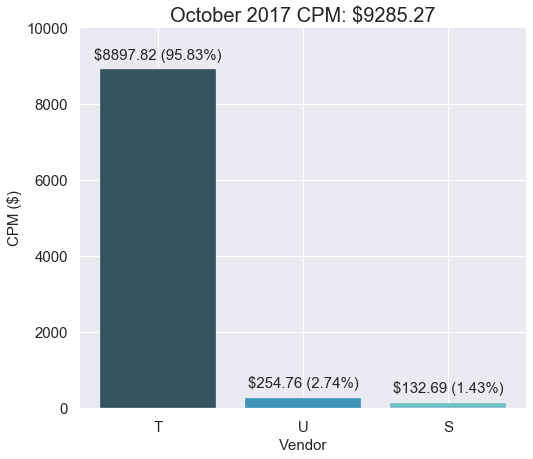

In [26]:
temp = oct_cpm.groupby(["vendor"]).sum().reset_index()[["vendor", "cpm"]].sort_values("cpm", ascending=False)
plt.figure(figsize=(8, 7))
graph = plt.bar(temp.vendor, temp.cpm, color=["C0", "C2", "C4"])
plt.title("October 2017 CPM: ${}".format(round(sum(temp.cpm), 2)), fontsize=20)
plt.xlabel("Vendor", fontsize=15)
plt.yticks(range(0, 12000, 2000),fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("CPM ($)",fontsize=15)
for bar, x in zip(graph, temp.cpm.values):
    plt.text(bar.get_x() + bar.get_width() / 2.0,
             bar.get_height() + 200,
             "${} ({}%)".format(round(x, 2),
                               round(x / sum(temp.cpm) * 100, 2)),
             fontsize=15,
             ha="center",
             va="bottom")
plt.show()

#### Vendor U Analysis

In [27]:
cur.execute("""
    SELECT 
        STRFTIME("%Y-%m-%d", DATE) date,
        STRFTIME("%m", DATE) as month,
        u.DEVICE_TYPE as mapper,
        groupings."Zone Name" as zone_name,
        groupings.Platform as platform, 
        groupings."Ad Products" as ad_products,
        u.VIDEO_IMPRESSIONS as sold_impressions,
        u.CLICKS as clicks,
        (CAST(u.VIDEO_IMPRESSIONS as REAL) / map.total_sold_impressions * map.total_est_revenue) as est_revenue,
        (CAST(u.VIDEO_IMPRESSIONS as REAL) / map.total_sold_impressions * map.total_est_revenue)/CAST(u.VIDEO_IMPRESSIONS as REAL)*1000 as cpm
    FROM vendor_u as u
    LEFT JOIN (SELECT
                    DATE as date,
                    CAST(sum(VIDEO_IMPRESSIONS) as REAL) as total_sold_impressions,
                    CAST(sum(EARNINGS) as REAL) as total_est_revenue
                FROM vendor_u
                GROUP by DATE) as map
        USING (DATE)
    LEFT JOIN definitions_groupings as groupings
        ON lower(u.DEVICE_TYPE) = lower(groupings.tagID)
    WHERE DEVICE_TYPE NOT LIKE "%UNKNOWN%"
    """)

df_u = pd.DataFrame(cur.fetchall(),
                             columns=[i[0] for i in cur.description])
df_u.head()

,date,month,mapper,zone_name,platform,ad_products,sold_impressions,clicks,est_revenue,cpm
0,2017-04-14,04,Desktop,ROS,Desktop,Full Page Ad/Inread Video,4265,1073,2.21,0.52
1,2017-02-13,02,Desktop,ROS,Desktop,Full Page Ad/Inread Video,8585,1286,56.77,6.61
2,2017-02-25,02,Desktop,ROS,Desktop,Full Page Ad/Inread Video,2806,282,8.35,2.98
3,2017-01-02,01,Desktop,ROS,Desktop,Full Page Ad/Inread Video,1801,371,7.45,4.13
4,2017-03-19,03,Desktop,ROS,Desktop,Full Page Ad/Inread Video,6241,51,8.08,1.29


In [28]:
df_report = df_u.profile_report(title="Vendor U", correlation_threshold_pearson = 1, sort = "None")
df_report

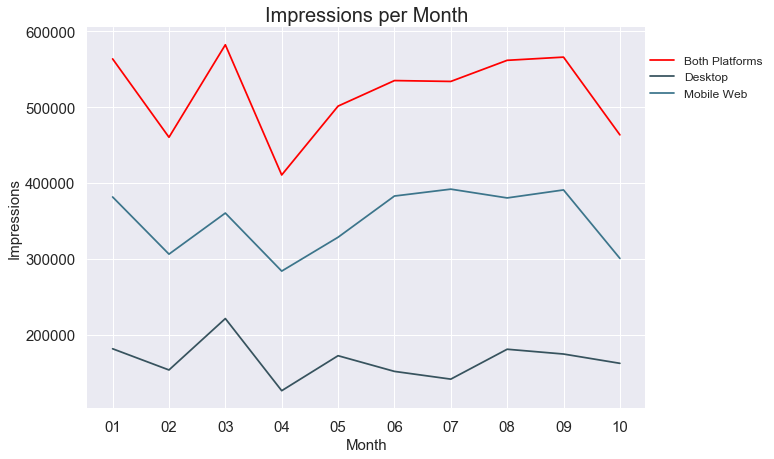

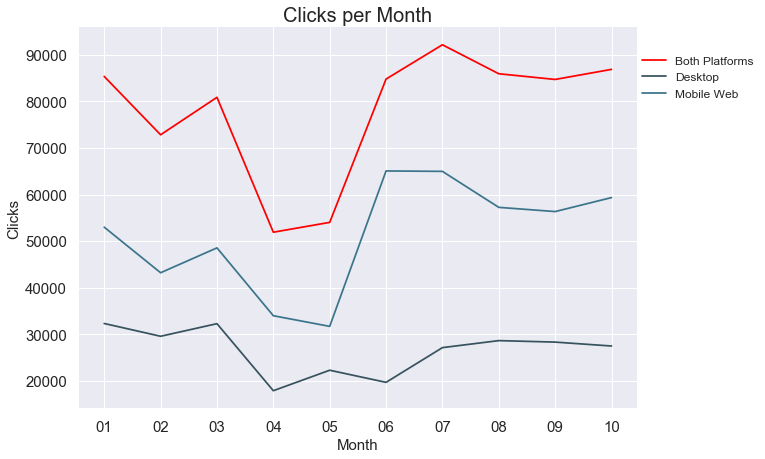

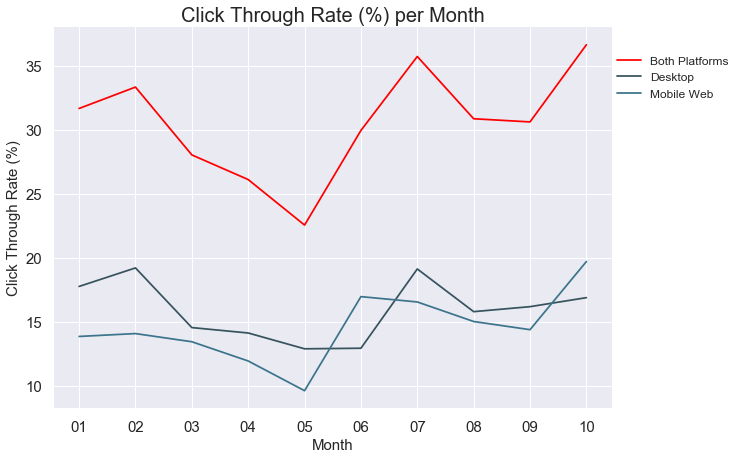

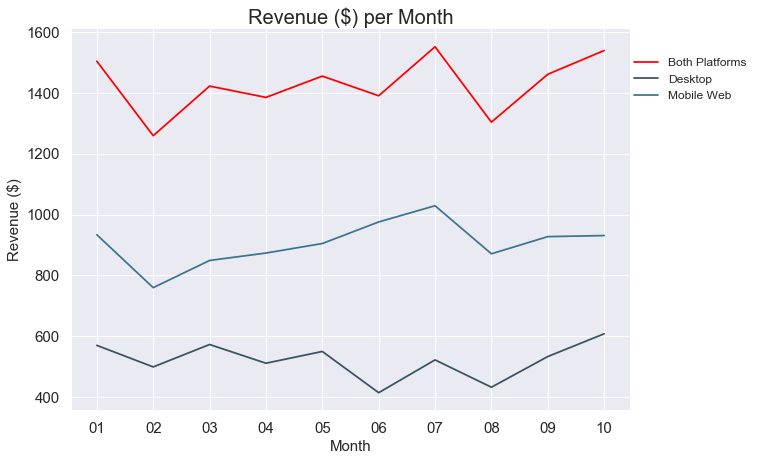

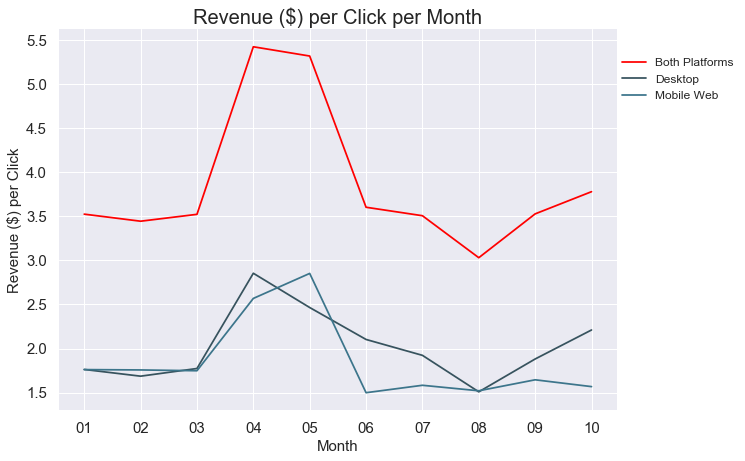

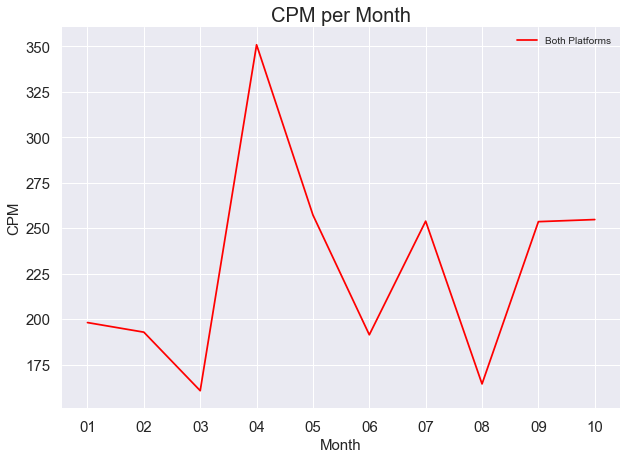

In [29]:
temp = df_u.groupby(["month", "platform"]).sum().reset_index()
temp["ctr"] = temp["clicks"] / temp["sold_impressions"] * 100
temp["revenue_per_click"] = temp["est_revenue"] / temp["clicks"] * 100

for col, title in {
        "sold_impressions": "Impressions",
        "clicks": "Clicks",
        "ctr": "Click Through Rate (%)",
        "est_revenue": "Revenue ($)",
        "revenue_per_click": "Revenue ($) per Click",
        "cpm": "CPM"
}.items():
    plt.figure(figsize=(10, 7))
    sns.lineplot(x="month",
                 y=col,
                 data=temp.groupby("month").sum().reset_index(),
                 color="red",
                 label="Both Platforms")
    if col != "cpm":
        graph = sns.lineplot(
            x="month",
            y=col,
            hue="platform",
            data=temp,
            color=["C2", "C4"],
        )
        handles, labels = graph.get_legend_handles_labels()
        handles.remove(handles[1])
        labels.remove(labels[1])
        plt.legend(handles=handles,
                   labels=labels,
                   loc=(1,.8),
                   fontsize=12)
    plt.xticks(range(0, 10, 1), fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Month", fontsize=15)
    plt.ylabel(title, fontsize=15)
    plt.title("{} per Month".format(title), fontsize=20)
    plt.show()

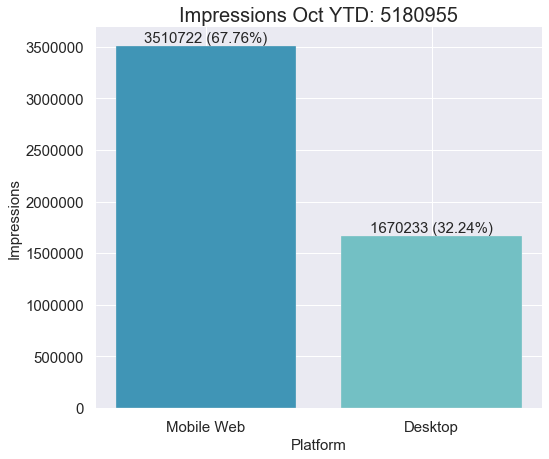

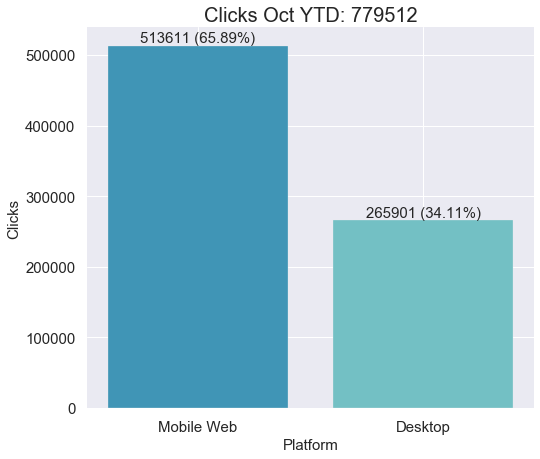

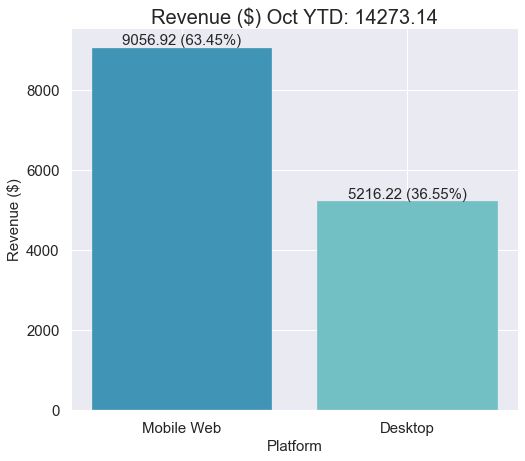

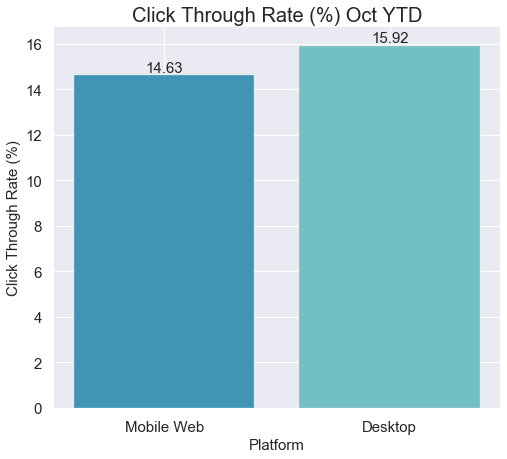

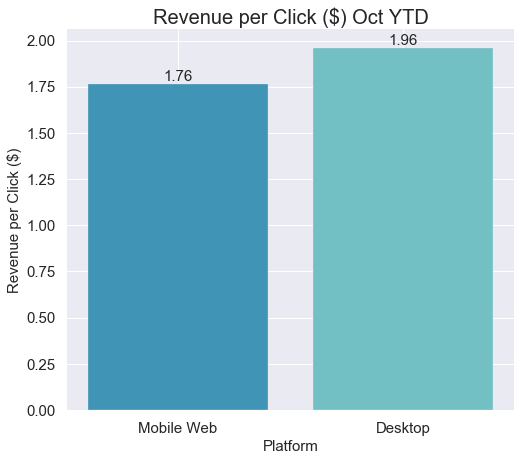

In [30]:
temp = df_u.groupby(["platform"]).sum().reset_index()
temp["ctr"] = temp["clicks"] / temp["sold_impressions"] * 100
temp["revenue_per_click"] = temp["est_revenue"] / temp["clicks"] * 100

for col, title in {
        "sold_impressions": "Impressions",
        "clicks": "Clicks",
        "est_revenue": "Revenue ($)"
}.items():
    plt.figure(figsize=(8, 7))
    temp = temp.sort_values(col, ascending=False)
    graph = plt.bar(temp.platform, temp[col], color=["C2", "C4"])
    plt.title("{} Oct YTD: {}".format(title, round(sum(temp[col]), 2)), fontsize=20)
    plt.xlabel("Platform", fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylabel(title, fontsize=15)
    for bar, x in zip(graph, temp[col].values):
        plt.text(bar.get_x() + bar.get_width() / 2.0,
                 bar.get_height(),
                 "{} ({}%)".format(round(x, 2),
                                   round(x / sum(temp[col]) * 100, 2)),
                 fontsize=15,
                 ha="center",
                 va="bottom")
    plt.show()
    
for col, title in {
        "ctr": "Click Through Rate (%)",
        "revenue_per_click": "Revenue per Click ($)"
}.items():
    plt.figure(figsize=(8, 7))
    graph = plt.bar(temp.platform, temp[col], color=["C2", "C4"])
    plt.title("{} Oct YTD".format(title), fontsize=20)
    plt.xlabel("Platform", fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.ylabel(title, fontsize=15)
    for bar, x in zip(graph, temp[col].values):
        plt.text(bar.get_x() + bar.get_width() / 2.0,
                 bar.get_height(),
                 "{}".format(round(x, 2)),
                 fontsize=15,
                 ha="center",
                 va="bottom")
    plt.show()

In [31]:
temp = df_u.groupby(["platform"]).sum().reset_index()
temp["ctr"] = temp["clicks"] / temp["sold_impressions"] * 100
temp["revenue_per_click"] = temp["est_revenue"] / temp["clicks"] * 100
temp

,platform,sold_impressions,clicks,est_revenue,cpm,ctr,revenue_per_click
0,Desktop,1670233,265901,5216.22,1138.81,15.92,1.96
1,Mobile Web,3510722,513611,9056.92,1138.81,14.63,1.76


In [32]:
temp = df_u.groupby(["month"]).sum().reset_index()
temp["ctr"] = temp["clicks"] / temp["sold_impressions"] * 100
temp["revenue_per_click"] = temp["est_revenue"] / temp["clicks"] * 100
temp

,month,sold_impressions,clicks,est_revenue,cpm,ctr,revenue_per_click
0,01,563877,85354,1504.08,198.09,15.14,1.76
1,02,460600,72838,1259.34,192.81,15.81,1.73
2,03,582466,80878,1422.48,160.60,13.89,1.76
3,04,410938,51933,1385.25,350.92,12.64,2.67
4,05,501646,54043,1455.24,257.25,10.77,2.69
5,06,535298,84793,1390.56,191.37,15.84,1.64
6,07,534166,92153,1551.66,253.88,17.25,1.68
7,08,561986,85935,1303.96,164.34,15.29,1.52
8,09,566198,84712,1461.19,253.61,14.96,1.72
9,10,463780,86873,1539.38,254.76,18.73,1.77
